In [12]:
import numpy as np
import os
from astropy.io import fits

Region = "ngc628"
Band = "F770W"
synthetic_dir = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/Synthetic"

original_image_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/FilPHANGS_Data/OriginalImages/ngc0628_F770W_JWST_Emission_starsub.fits"

# Load original image and its header
with fits.open(original_image_path) as hdul:
    orig_image_data = hdul[0].data
    original_header = hdul[0].header

# Replace NaNs with zeros
orig_image_data = np.nan_to_num(orig_image_data, nan=0.0)

# Prepare an empty reconstruction array
reconstructed_image = np.zeros_like(orig_image_data)

# Iterate over synthetic FITS files
for file in os.listdir(synthetic_dir):
    file_path = os.path.join(synthetic_dir, file)

    # Skip non-FITS or unwanted files
    if (not file.endswith('.fits')) or ("Reconstruction" in file) or ("Subtraction" in file):
        continue

    # Force open the FITS file even if header is bad
    hdul = fits.open(file_path, ignore_missing_simple=True, do_not_scale_image_data=True)
    image_data = 3.27*.5*hdul[0].data
    hdul.close()

    # Skip if shapes don't match
    if image_data.shape != orig_image_data.shape:
        print(f"Shape mismatch: Original image shape {orig_image_data.shape}, synthetic map {file} shape: {image_data.shape}")
        continue

    # Accumulate reconstruction
    reconstructed_image += image_data
    print(f"Added {file}: max value so far = {np.max(reconstructed_image)}")

# Create and save reconstructed image with a new header
recon_header = fits.Header()
recon_header['REGION'] = Region
recon_header['BAND'] = Band
recon_header['COMMENT'] = "Summed synthetic reconstruction image"

recon_path = os.path.join(synthetic_dir, f"Reconstruction_of_Original_{Region}_{Band}.fits")
fits.PrimaryHDU(reconstructed_image, header=recon_header).writeto(recon_path, overwrite=True)

# Subtract and save result
subtracted_image = orig_image_data - reconstructed_image

sub_header = fits.Header()
sub_header['REGION'] = Region
sub_header['BAND'] = Band
sub_header['COMMENT'] = "Original minus synthetic reconstruction"

sub_path = os.path.join(synthetic_dir, f"SubtractionOfOriginalAndSynthetic_{Region}_{Band}.fits")
fits.PrimaryHDU(subtracted_image, header=sub_header).writeto(sub_path, overwrite=True)


Added ngc0628_F770W_CDDss0032pc_FinalSyntheticMap_1001.fits: max value so far = nan
Added ngc0628_F770W_CDDss0016pc_FinalSyntheticMap_1001.fits: max value so far = nan
Added ngc0628_F770W_CDDss0064pc_FinalSyntheticMap_1001.fits: max value so far = nan
Added ngc0628_F770W_CDDss00256pc_FinalSyntheticMap_1001.fits: max value so far = nan
Added ngc0628_F770W_CDDss00128pc_FinalSyntheticMap_1001.fits: max value so far = nan


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_3252/1140425778.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)


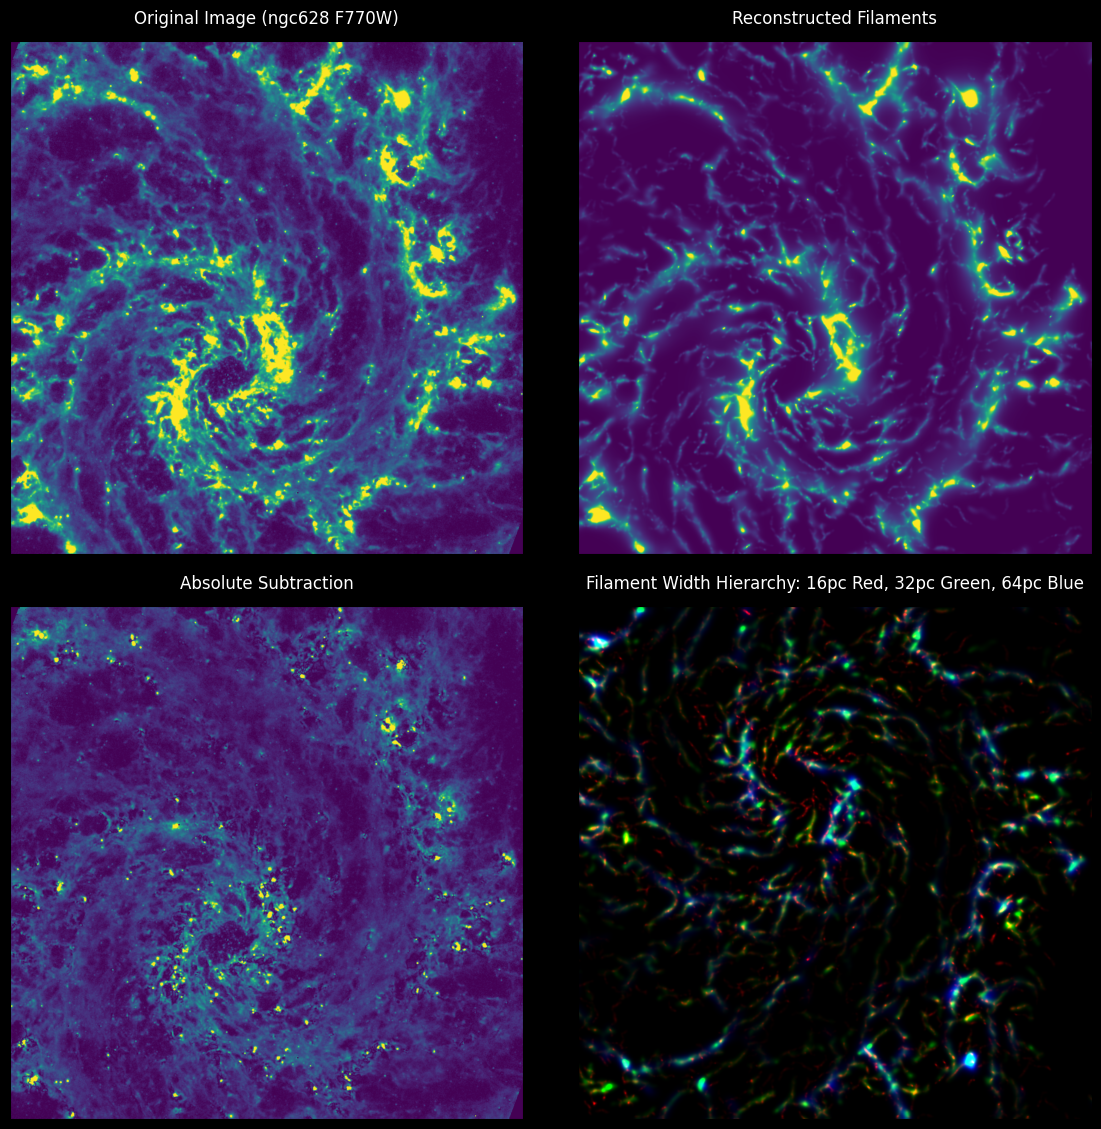

✅ Figure saved to: /Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/Synthetic/FourPanel_ngc628_F770W_Hierarchy.png


In [72]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from PIL import Image  # For loading PNG files

# --- Configuration ---
Region = "ngc628"
Band = "F770W"
synthetic_dir = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/Synthetic"
original_image_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/FilPHANGS_Data/OriginalImages/ngc0628_F770W_JWST_Emission_starsub.fits"
hierarchy_path = os.path.join(synthetic_dir, "Hierarchy.png")  # Now using PNG

# --- Load Images ---
orig_image = np.nan_to_num(fits.getdata(original_image_path), nan=0.0)
recon_image = np.nan_to_num(fits.getdata(os.path.join(synthetic_dir, f"Reconstruction_of_Original_{Region}_{Band}.fits")), nan=0.0)
sub_image = np.nan_to_num(fits.getdata(os.path.join(synthetic_dir, f"SubtractionOfOriginalAndSynthetic_{Region}_{Band}.fits")), nan=0.0)
sub_image_abs = np.abs(sub_image)

# Load PNG hierarchy image
hierarchy_rgb = np.array(Image.open(hierarchy_path))  # Load as RGB array

# --- Contrast Stretching ---
vmin, vmax = np.percentile(orig_image, [1, 99])

# Function to set zero pixels to black
def set_zero_to_black(image):
    image_copy = np.copy(image)
    image_copy[image_copy == 0] = np.nan  # Replace zero values with NaN
    return np.nan_to_num(image_copy, nan=0)

# --- Cropping Parameters (centered square crop) ---
def crop_center(image):
    height, width = image.shape[:2]
    side = min(height, width) // 2  # Use 50% of the smaller dimension
    y_center = height // 2
    x_center = width // 2
    y_start, y_end = y_center - side // 2, y_center + side // 2
    x_start, x_end = x_center - side // 2, x_center + side // 2
    return image[y_start:y_end, x_start:x_end]

# Apply zero masking and crop to all images
orig_crop = crop_center(set_zero_to_black(orig_image))
recon_crop = crop_center(set_zero_to_black(recon_image))
sub_crop = crop_center(set_zero_to_black(sub_image_abs))
hierarchy_crop = crop_center(hierarchy_rgb)

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 14), facecolor='black',
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# Display function
def display_image(ax, image, title, cmap='viridis', title_y=1.02):
    if image.ndim == 2:  # grayscale
        ax.imshow(image, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    else:  # RGB image
        ax.imshow(image, origin='lower')
    ax.set_title(title, color='white', pad=5, y=title_y)
    ax.set_facecolor('black')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Plot each panel
display_image(axs[0, 0], orig_crop, "Original Image (ngc628 F770W)")
display_image(axs[0, 1], recon_crop, "Reconstructed Filaments")
display_image(axs[1, 0], sub_crop, "Absolute Subtraction")
display_image(axs[1, 1], hierarchy_crop, "Filament Width Hierarchy: 16pc Red, 32pc Green, 64pc Blue")

# Save figure
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
out_path = os.path.join(synthetic_dir, f"FourPanel_{Region}_{Band}_Hierarchy.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

print(f"✅ Figure saved to: {out_path}")
